
## Requirements

In [179]:
import numpy as np
import collections
import pandas as pd
import nltk
import pickle
from nltk.util import bigrams
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, make_scorer, accuracy_score
from sklearn.metrics import confusion_matrix

In [31]:
# requires to be connected to a properly configured python environment with tensorflow etc.
import tensorflow as tf
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()
from tensorflow import keras
from keras import models
from keras import layers
tf.__version__

'2.5.0'

In [48]:
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
# import preprocessed data - see `CLASSIFICATION_FEATURE+LABELS-EXTRACTION.ipynb`

# X - features
features_statuslist = pickle.load(open("../data/large_data/features_statuslist.pickle", "rb"))
features_10000bigrams = pickle.load(open("../data/large_data/features_10000bigrams.pickle", "rb"))
features_material =  pickle.load(open("../data/large_data/features_material.pickle", "rb"))
features_weightedbigrams = pickle.load(open("../data/large_data/features_weightedbigrams.pickle", "rb"))
# one specific combination of features:
features = np.hstack([features_statuslist, features_10000bigrams, features_material])

In [12]:
# y - labels/target
one_hot_labels = pickle.load(open("../data/large_data/one_hot_labels.pickle", "rb"))

## Neural Networks Model Development

In [46]:
# TRAIN vs TEST
subset_size = len(features)

x_train_full, x_test, y_train_full, y_test = train_test_split(features[:subset_size], one_hot_labels[:subset_size], test_size=0.1)

# actual TRAIN vs. internal VALIDATION data
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.1)

# to see the actual shape of the data
print(
    x_train.shape,
    y_train.shape,
    x_val.shape,
    y_val.shape,
    x_test.shape,
    y_test.shape)

(37397, 10055) (37397, 22) (4156, 10055) (4156, 22) (4618, 10055) (4618, 22)


In [19]:
# since our classes are highly unbalanced w1 weighted is perhaps the best metric for model performance
def f1_weighted(y_true, y_pred):
    y_true = np.ndarray.argmax(y_true.numpy(), axis=1)
    y_pred = np.ndarray.argmax(y_pred.numpy(), axis=1)
    return f1_score(y_true, y_pred, average="weighted")

In [27]:
# based on https://www.dlology.com/blog/multi-class-classification-with-focal-loss-for-imbalanced-datasets/
def focal_loss(gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        https://arxiv.org/abs/1708.02002
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [79]:
model = Sequential()
model.add(Dense(2048, activation='relu', input_shape=(len(x_train[0]),)))
model.add(Dense(2048, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(22, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss=focal_loss(alpha=1), # 'categorical_crossentropy',
              metrics=["accuracy", f1_weighted])

history = model.fit(x_train,
          y_train,
          epochs=8,
          batch_size=1024,
          verbose=1,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, y_test)

Epoch 1/8
37/37 [==============================] - 15s 397ms/step - loss: 0.8032 - accuracy: 0.7001 - f1_weighted: 0.6373 - val_loss: 0.4142 - val_accuracy: 0.8383 - val_f1_weighted: 0.8285
Epoch 2/8
37/37 [==============================] - 15s 401ms/step - loss: 0.2632 - accuracy: 0.8795 - f1_weighted: 0.8639 - val_loss: 0.2815 - val_accuracy: 0.8645 - val_f1_weighted: 0.8662
Epoch 3/8
37/37 [==============================] - 14s 380ms/step - loss: 0.1966 - accuracy: 0.9043 - f1_weighted: 0.8941 - val_loss: 0.3185 - val_accuracy: 0.8571 - val_f1_weighted: 0.8654
Epoch 4/8
37/37 [==============================] - 14s 377ms/step - loss: 0.1614 - accuracy: 0.9184 - f1_weighted: 0.9106 - val_loss: 0.2993 - val_accuracy: 0.8696 - val_f1_weighted: 0.8726
Epoch 5/8
37/37 [==============================] - 14s 381ms/step - loss: 0.1449 - accuracy: 0.9266 - f1_weighted: 0.9210 - val_loss: 0.2923 - val_accuracy: 0.8816 - val_f1_weighted: 0.8799
Epoch 6/8
37/37 [==============================] -

In [80]:
results

[0.3015522360801697, 0.8826332092285156, 0.8741804361343384]

## Model evaluation

### Exploring overfitting

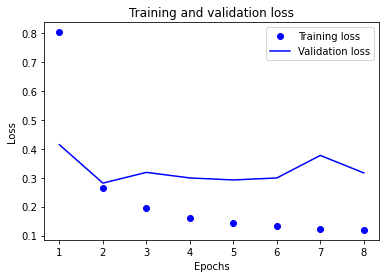

In [81]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

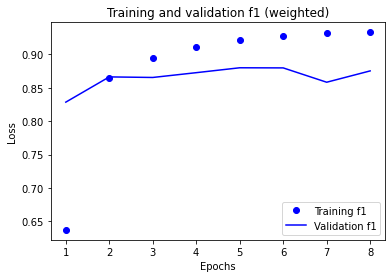

In [82]:
plt.clf()   # clear figure

f1 = history.history['f1_weighted']
val_f1 = history.history['val_f1_weighted']

plt.plot(epochs, f1, 'bo', label='Training f1')
plt.plot(epochs, val_f1, 'b', label='Validation f1')
plt.title('Training and validation f1 (weighted)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [83]:
predictions = model.predict(x_test)

In [84]:
predictions.round(4)

array([[0.0e+00, 5.0e-04, 0.0e+00, ..., 1.1e-03, 0.0e+00, 1.0e-03],
       [0.0e+00, 0.0e+00, 0.0e+00, ..., 0.0e+00, 0.0e+00, 0.0e+00],
       [0.0e+00, 2.0e-03, 0.0e+00, ..., 4.0e-03, 0.0e+00, 3.1e-03],
       ...,
       [0.0e+00, 0.0e+00, 0.0e+00, ..., 0.0e+00, 0.0e+00, 0.0e+00],
       [0.0e+00, 7.0e-04, 0.0e+00, ..., 1.0e-04, 0.0e+00, 1.7e-03],
       [0.0e+00, 0.0e+00, 0.0e+00, ..., 0.0e+00, 0.0e+00, 0.0e+00]],
      dtype=float32)

In [85]:
y_predicted = np.ndarray.argmax(predictions, axis=1) # .

In [86]:
y_test_simple = np.ndarray.argmax(y_test, axis=1)

In [148]:
labels_sorted_tups = sorted(list(collections.Counter(y_test_simple).items()), key=lambda x: x[1], reverse=True)
labels_sorted = [l[0] for l in labels_sorted_tups]
labels_sorted

[5, 9, 21, 12, 4, 14, 1, 8, 16, 19, 15, 0, 6, 13, 2, 7, 3, 10, 18, 17, 11]

In [149]:
labels10 = labels_sorted[:10]

In [105]:
np.unique(y_test_simple, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 21]),
 array([  22,   71,   11,    7,  242, 2156,   19,    8,   34, 1171,    3,
           1,  326,   18,  122,   23,   29,    1,    2,   25,  327]))

In [88]:
labels_dict = pickle.load(open("../data/labels_dict.pickle", "rb"))
labels_dict

{'military diploma': 0,
 'identification inscription': 1,
 'letter': 2,
 'seat inscription': 3,
 'building/dedicatory inscription': 4,
 'epitaph': 5,
 'elogium': 6,
 'public legal inscription': 7,
 'acclamation': 8,
 'votive inscription': 9,
 'calendar': 10,
 'assignation inscription': 11,
 'honorific inscription': 12,
 'label': 13,
 'mile-/leaguestone': 14,
 'boundary inscription': 15,
 'defixio': 16,
 'prayer': 17,
 'private legal inscription': 18,
 'list': 19,
 'adnuntiatio': 20,
 'owner/artist inscription': 21}

In [89]:
labels_dict_inv = dict(zip(labels_dict.values(), labels_dict.keys()))
labels_dict_inv

{0: 'military diploma',
 1: 'identification inscription',
 2: 'letter',
 3: 'seat inscription',
 4: 'building/dedicatory inscription',
 5: 'epitaph',
 6: 'elogium',
 7: 'public legal inscription',
 8: 'acclamation',
 9: 'votive inscription',
 10: 'calendar',
 11: 'assignation inscription',
 12: 'honorific inscription',
 13: 'label',
 14: 'mile-/leaguestone',
 15: 'boundary inscription',
 16: 'defixio',
 17: 'prayer',
 18: 'private legal inscription',
 19: 'list',
 20: 'adnuntiatio',
 21: 'owner/artist inscription'}

### Confusion matrix for all predictions

In [155]:
matrix = confusion_matrix(
    y_test_simple,
    y_predicted,
    normalize="true", #
    labels=labels_sorted
    )
dataframe = pd.DataFrame(matrix, columns=labels_sorted, index=labels_sorted)
dataframe

,5,9,21,12,4,14,1,8,16,19,...,0,6,13,2,7,3,10,18,17,11
5,0.953154,0.023655,0.001391,0.013451,0.006494,0.000000,0.000464,0.000000,0.000000,0.000464,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000928,0.0,0.000000,0.0,0.0
9,0.026473,0.931682,0.005124,0.010248,0.024765,0.000000,0.000854,0.000000,0.000854,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
21,0.042813,0.039755,0.874618,0.000000,0.006116,0.000000,0.015291,0.009174,0.000000,0.000000,...,0.0,0.000000,0.006116,0.006116,0.000000,0.000000,0.0,0.000000,0.0,0.0
12,0.079755,0.046012,0.000000,0.809816,0.049080,0.006135,0.000000,0.000000,0.000000,0.003067,...,0.0,0.003067,0.000000,0.000000,0.000000,0.000000,0.0,0.003067,0.0,0.0
4,0.049587,0.235537,0.016529,0.078512,0.586777,0.012397,0.004132,0.000000,0.000000,0.004132,...,0.0,0.000000,0.000000,0.000000,0.004132,0.008264,0.0,0.000000,0.0,0.0
14,0.008197,0.008197,0.000000,0.040984,0.040984,0.901639,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
1,0.253521,0.084507,0.380282,0.014085,0.028169,0.000000,0.197183,0.028169,0.000000,0.000000,...,0.0,0.000000,0.000000,0.014085,0.000000,0.000000,0.0,0.000000,0.0,0.0
8,0.176471,0.088235,0.323529,0.000000,0.029412,0.000000,0.088235,0.294118,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
16,0.034483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.931034,0.000000,...,0.0,0.000000,0.000000,0.000000,0.034483,0.000000,0.0,0.000000,0.0,0.0
19,0.080000,0.240000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.520000,...,0.0,0.000000,0.000000,0.040000,0.000000,0.000000,0.0,0.040000,0.0,0.0


In [161]:
dataframe = dataframe.loc[labels10, labels10]

In [129]:
dataframe.rename(columns=labels_dict_inv, index=labels_dict_inv, inplace=True)
dataframe

,military diploma,identification inscription,letter,seat inscription,building/dedicatory inscription,epitaph,elogium,public legal inscription,acclamation,votive inscription,...,assignation inscription,honorific inscription,label,mile-/leaguestone,boundary inscription,defixio,prayer,private legal inscription,list,adnuntiatio
military diploma,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
identification inscription,0.0,0.197183,0.014085,0.000000,0.028169,0.253521,0.000000,0.000000,0.028169,0.084507,...,0.0,0.014085,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.380282
letter,0.0,0.000000,0.909091,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.090909,0.000000
seat inscription,0.0,0.000000,0.000000,0.000000,0.714286,0.000000,0.000000,0.000000,0.000000,0.285714,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
building/dedicatory inscription,0.0,0.004132,0.000000,0.008264,0.586777,0.049587,0.000000,0.004132,0.000000,0.235537,...,0.0,0.078512,0.000000,0.012397,0.000000,0.000000,0.0,0.000000,0.004132,0.016529
epitaph,0.0,0.000464,0.000000,0.000928,0.006494,0.953154,0.000000,0.000000,0.000000,0.023655,...,0.0,0.013451,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000464,0.001391
elogium,0.0,0.000000,0.000000,0.000000,0.000000,0.157895,0.631579,0.000000,0.000000,0.000000,...,0.0,0.210526,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
public legal inscription,0.0,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.125000,0.000000,0.125000,...,0.0,0.125000,0.000000,0.000000,0.000000,0.000000,0.0,0.500000,0.000000,0.000000
acclamation,0.0,0.088235,0.000000,0.000000,0.029412,0.176471,0.000000,0.000000,0.294118,0.088235,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.323529
votive inscription,0.0,0.000854,0.000000,0.000000,0.024765,0.026473,0.000000,0.000000,0.000000,0.931682,...,0.0,0.010248,0.000000,0.000000,0.000000,0.000854,0.0,0.000000,0.000000,0.005124


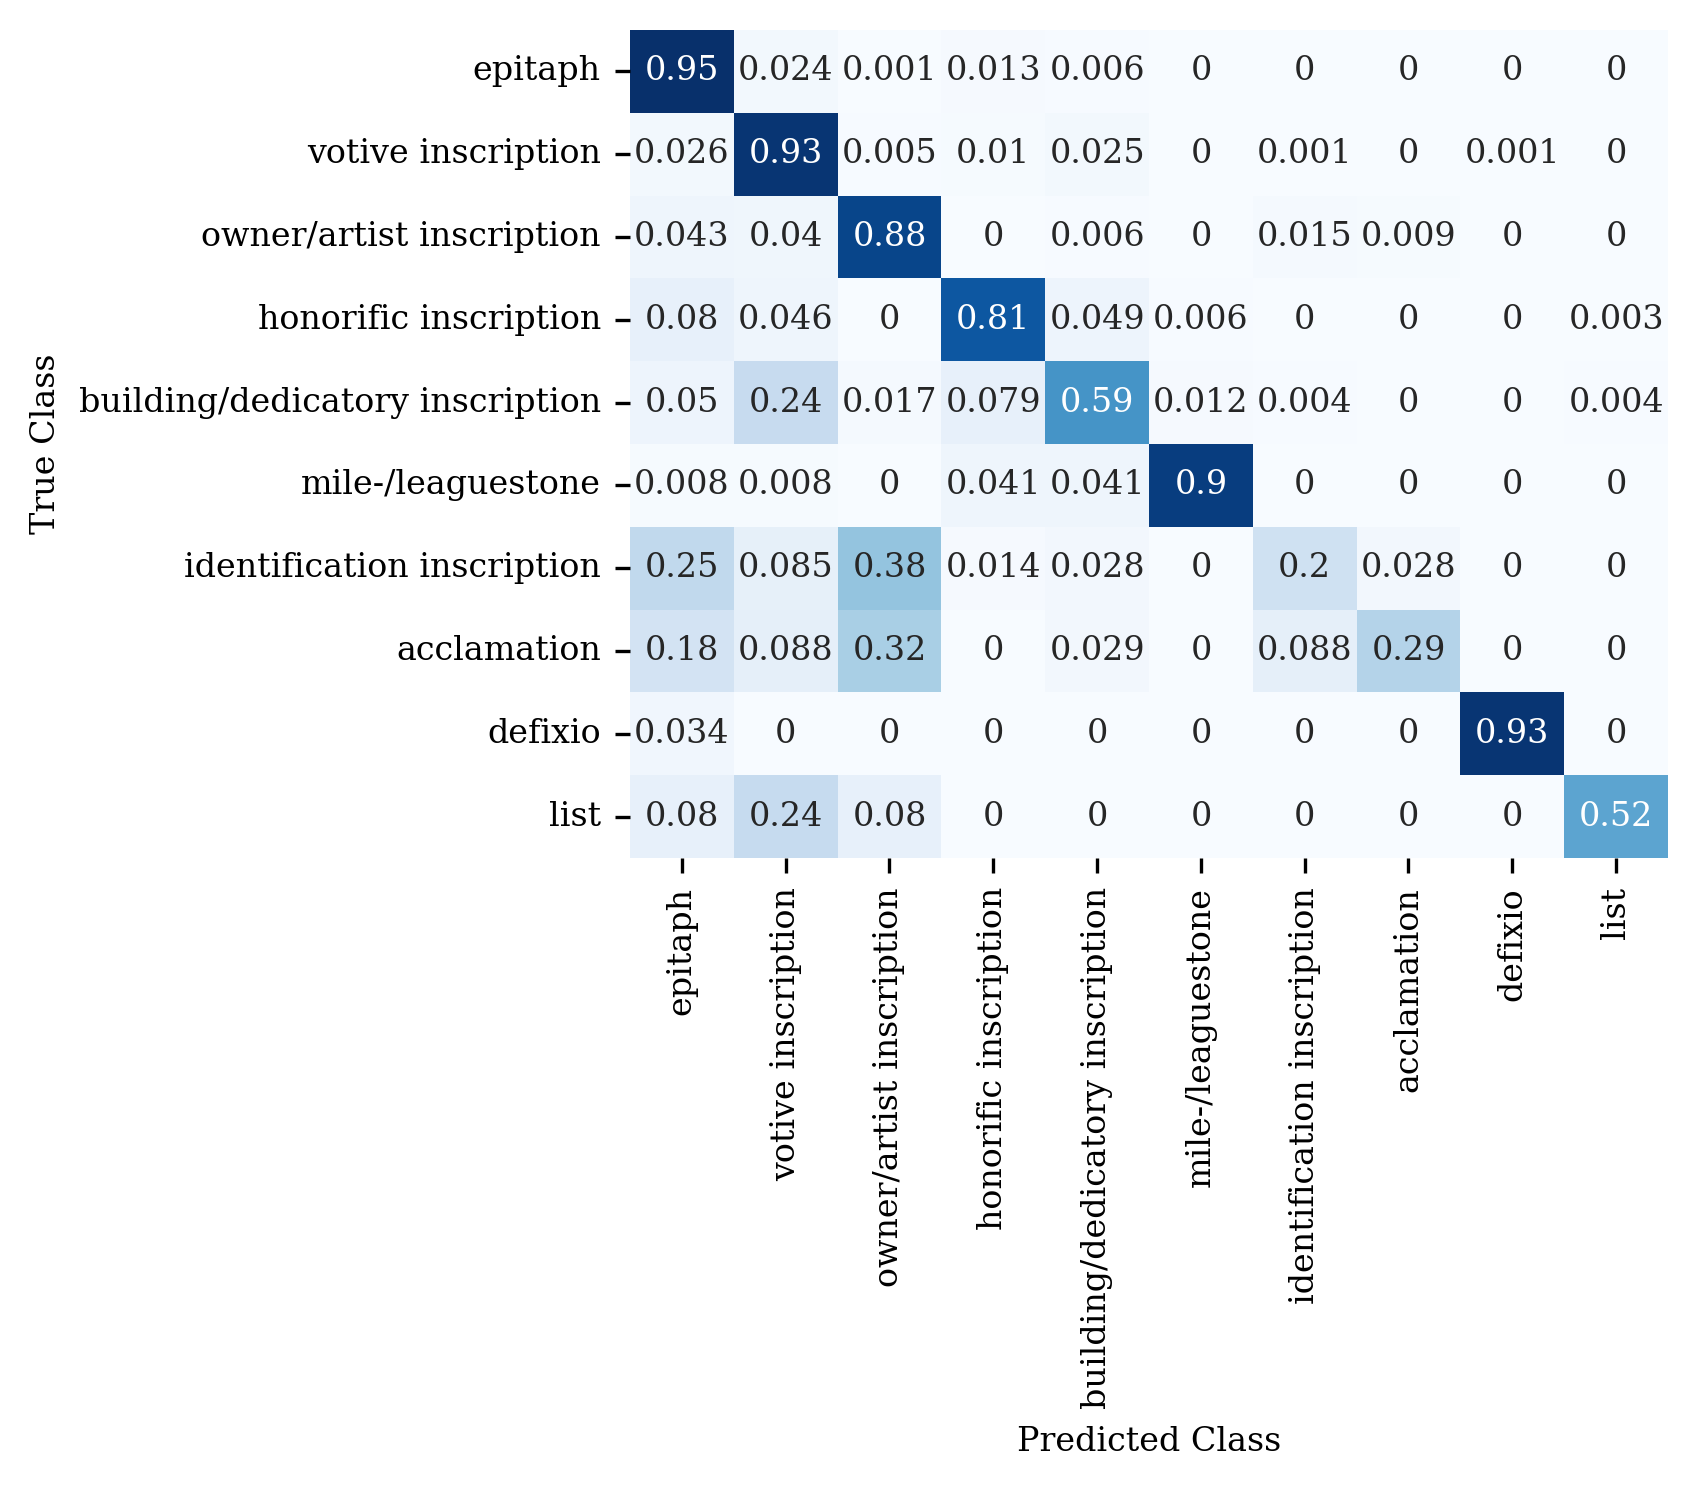

In [163]:
plt.style.use("fast")
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 8

fig, ax = plt.subplots(figsize=(5.7, 5), dpi=300, tight_layout=True)

sns.heatmap(dataframe.round(3), annot=True, cbar=None, cmap="Blues", ax=ax)

ax.set_ylabel("True Class")
ax.set_xlabel("Predicted Class")
plt.show()

### Confusion matrix for predictions above probability threshold

In [ ]:
# extract probabilities
y_prediceted_prob = np.ndarray.max(predictions, axis=1)

In [177]:
# combine true values, probability, and predicted values
test_pred_probs = np.vstack([y_predicted, y_prediceted_prob, y_test_simple]).T
test_pred_probs

array([[ 9.        ,  0.9822306 ,  9.        ],
       [14.        ,  0.99855262, 14.        ],
       [ 9.        ,  0.84808844,  5.        ],
       ...,
       [ 5.        ,  0.97720569,  5.        ],
       [ 9.        ,  0.99027866,  9.        ],
       [ 5.        ,  0.99392337,  5.        ]])

In [180]:
test_results = []
for threshold in [thres / 100 for thres in range(
        30, 100, 5)]:
    above_threshold = [tup for tup in test_pred_probs if tup[1] >= threshold]
    f1 = f1_score([tup[2] for tup in above_threshold], [tup[0] for tup in above_threshold], average="weighted")
    accuracy = accuracy_score([tup[2] for tup in above_threshold], [tup[0] for tup in above_threshold], normalize=True)
    proportion = len(above_threshold) / len(test_pred_probs)
    test_results.append({"threshold (=/>)" : threshold, "proportion" : np.round(proportion, 2), "N" : len(above_threshold), "$F_1(w)$" : f1 ,"accuracy" : accuracy})
test_results_df = pd.DataFrame(test_results)
test_results_df

,threshold (=/>),proportion,N,$F_1(w)$,accuracy
0,0.30,0.95,4370,0.908721,0.912128
1,0.35,0.94,4341,0.912458,0.915688
2,0.40,0.92,4262,0.922110,0.924683
3,0.45,0.89,4120,0.927325,0.929854
4,0.50,0.87,4019,0.935478,0.937795
5,0.55,0.83,3825,0.943852,0.945359
6,0.60,0.80,3689,0.951776,0.952833
7,0.65,0.78,3586,0.956850,0.958171
8,0.70,0.75,3462,0.961232,0.962449
9,0.75,0.71,3291,0.964746,0.965664


In [182]:
threshold = 0.6
above_threshold = [tup for tup in test_pred_probs if tup[1] >= threshold]
matrix = confusion_matrix([tup[2] for tup in above_threshold], [tup[0] for tup in above_threshold], labels=labels10, normalize="true")
dataframe = pd.DataFrame(matrix, columns=labels10, index=labels10)
dataframe.rename(columns=labels_dict_inv, index=labels_dict_inv, inplace=True)
dataframe

,epitaph,votive inscription,owner/artist inscription,honorific inscription,building/dedicatory inscription,mile-/leaguestone,identification inscription,acclamation,defixio,list
epitaph,0.978665,0.008753,0.000000,0.009300,0.002188,0.000000,0.000547,0.000,0.0,0.000547
votive inscription,0.002844,0.976303,0.000948,0.004739,0.015166,0.000000,0.000000,0.000,0.0,0.000000
owner/artist inscription,0.000000,0.006369,0.980892,0.000000,0.006369,0.000000,0.006369,0.000,0.0,0.000000
honorific inscription,0.026718,0.030534,0.000000,0.908397,0.030534,0.003817,0.000000,0.000,0.0,0.000000
building/dedicatory inscription,0.006711,0.221477,0.026846,0.067114,0.671141,0.006711,0.000000,0.000,0.0,0.000000
mile-/leaguestone,0.000000,0.000000,0.000000,0.019048,0.019048,0.961905,0.000000,0.000,0.0,0.000000
identification inscription,0.058824,0.000000,0.352941,0.058824,0.058824,0.000000,0.470588,0.000,0.0,0.000000
acclamation,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.875,0.0,0.000000
defixio,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,1.0,0.000000
list,0.062500,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.0,0.687500


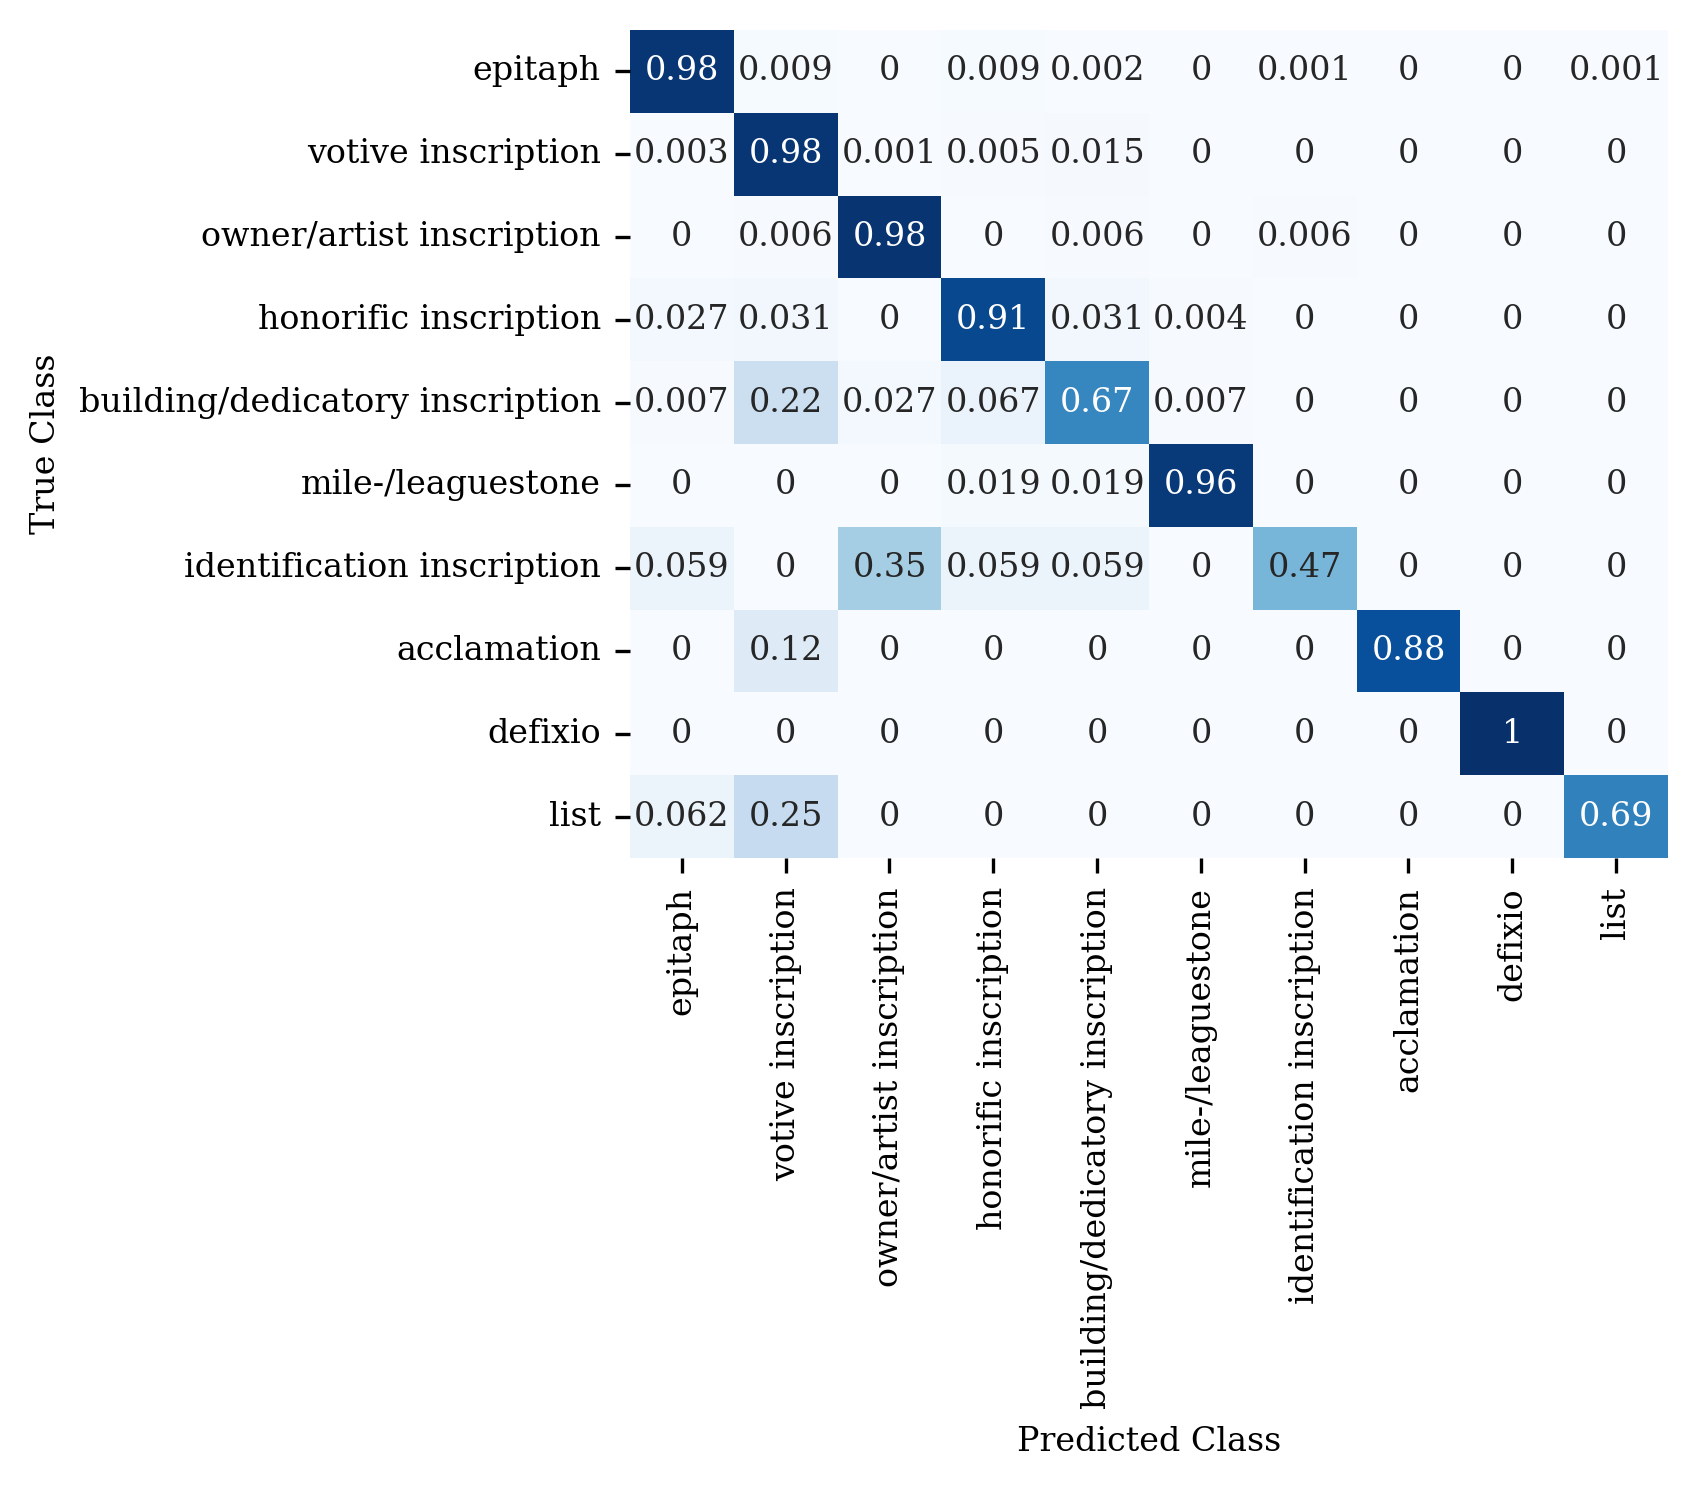

In [183]:
plt.style.use("fast")
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 8

fig, ax = plt.subplots(figsize=(5.7, 5), dpi=300, tight_layout=True)

sns.heatmap(dataframe.round(3), annot=True, cbar=None, cmap="Blues", ax=ax)

ax.set_ylabel("True Class")
ax.set_xlabel("Predicted Class")
plt.show()